# Configs and Imports

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import gc

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90
ES_ROUNDS = 150
ES_LOG_STEPS = 500

TRAIN_PATH = '/kaggle/input/playground-series-s4e7/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s4e7/test.csv'
ORIGINAL_PATH = '/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv'

# Loading and Processing The Datasets

In [3]:
class DataLoader:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        
        gender_mapping = {'Male': 0, 'Female': 1}
        vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
        vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
        dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
        dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
        dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)
        
        return dataframe
    
    @staticmethod
    def convert_data_types(dataframe):  
        print('--- Converting data types')
        
        dataframe['Region_Code'] = dataframe['Region_Code'].astype(int) 
        dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int) 
        dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int) 
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print("--- Adding new features")
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        # Beware of data leakage
        dataframe['Previously_Insured_Annual_Premium'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Annual_Premium'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Age'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Age'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Damage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Damage'].astype(str))[0]
        dataframe['Previously_Insured_Vintage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vintage'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

        return dataframe

    def load(self):
        print(f'Loading data')
        
        train = pd.read_csv(self.train_path, index_col='id')
        test = pd.read_csv(self.test_path, index_col='id')
        
        train = pd.concat([train, pd.read_csv(ORIGINAL_PATH, index_col='id')]).reset_index(drop=True) 
        train = train.drop_duplicates(keep="last").reset_index(drop=True)
        
        train['is_train'] = 1
        test['is_train'] = 0
        dataframe = pd.concat([train, test])
        del train, test
        gc.collect()
        
        dataframe = self.encode_categorical_features(dataframe)
        dataframe = self.convert_data_types(dataframe)
        dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        train = dataframe[dataframe['is_train'] == 1].drop(columns=['is_train'])
        test = dataframe[dataframe['is_train'] == 0].drop(columns=['is_train', TARGET])
        
        del dataframe
        gc.collect()
        
        train[TARGET] = train[TARGET].astype(np.int8)
        
        return train, test

In [4]:
train, test = DataLoader(TRAIN_PATH, TEST_PATH).load()

X = train.drop(columns=TARGET)
y = train[TARGET]

Loading data
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 2536.34 MB
------ Memory usage after: 634.09 MB
------ Decreased memory usage by 75.0%


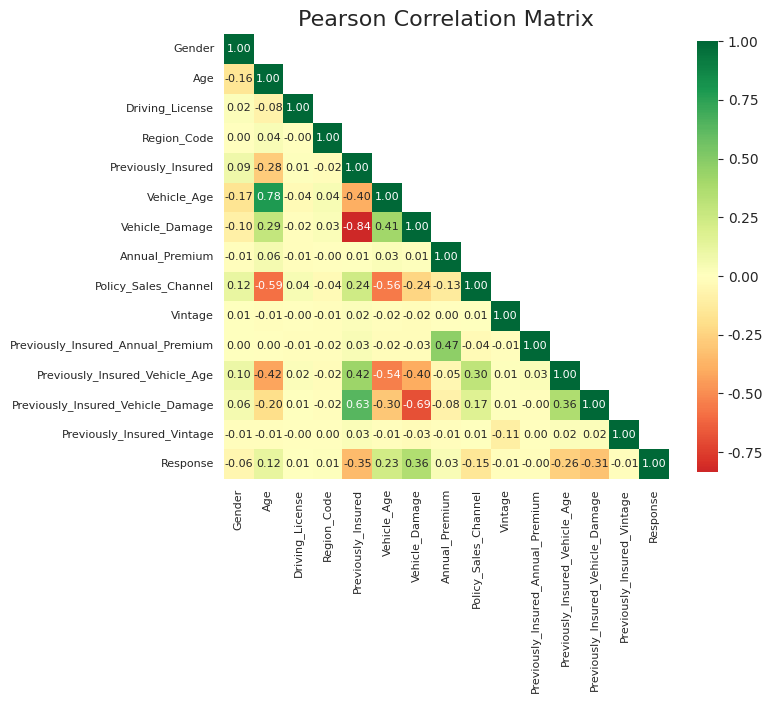

10

In [5]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))

cols = list(X.columns) + [TARGET]
temp_train = train[cols]

corr_train = temp_train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

del temp_train, corr_train, mask_train
gc.collect()

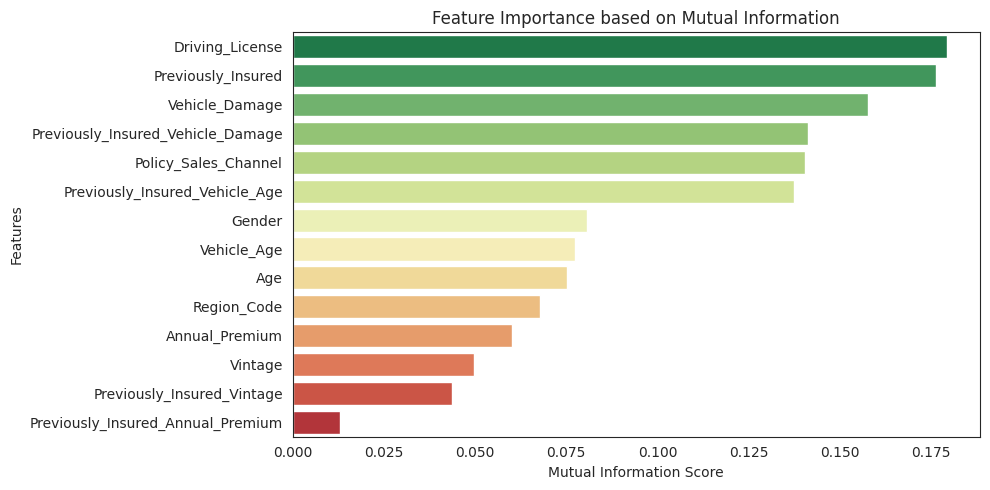

5650

In [6]:
train_mi = train.copy()
train_mi = train_mi.sample(1000_000)
X_mi = train_mi.drop(columns=TARGET)
y_mi = train_mi[TARGET]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])

plt.figure(figsize=(10, 5))
sns.barplot(x=mutual_info['Mutual Information'], y=mutual_info.index, palette='RdYlGn_r')
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

del train_mi, X_mi, y_mi
gc.collect()

# Training

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        feature_importances = np.zeros(X.shape[1])
        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        test_preds = []
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
            val_pool = Pool(X_val, y_val, cat_features=X_val.columns.values)
            test_pool = Pool(X_test, cat_features=X_test.columns.values)
            
            model = clone(self.model)
            model.fit(
                X=train_pool, 
                eval_set=val_pool, 
                verbose=ES_LOG_STEPS, 
                early_stopping_rounds=ES_ROUNDS,
                use_best_model=True
            )
            
            feature_importances += model.feature_importances_ / self.n_folds
            
            y_pred_probs = model.predict_proba(val_pool)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(test_pool)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            test_preds.append(temp_test_pred_probs[:, 1])
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs, temp_test_pred_probs, train_pool, val_pool, test_pool
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_preds, np.mean(scores))
        
        gc.collect()
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

        return oof_pred_probs, scores, feature_importances
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_preds, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        sub['id'] = sub['id']
        sub[TARGET] = np.mean(test_preds, axis=0)
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [8]:
model = CatBoostClassifier(
    # Reference: https://www.kaggle.com/code/ivanmitriakhin/5-fold-catboost-cv-0-89485-lb-0-89629
    loss_function='Logloss',
    eval_metric='AUC',
    class_names=[0, 1],
    learning_rate=0.075,
    iterations=5000,
    depth=9,
    random_strength=0,
    l2_leaf_reg=0.5,
    max_leaves=512,
    fold_permutation_block=64,
    task_type='GPU',
    random_seed=SEED,
    verbose=False
)
trainer = Trainer(model)
oof_pred_probs, scores, feature_importances = trainer.fit_predict(X, y, test)

Training CatBoostClassifier



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8750178	best: 0.8750178 (0)	total: 9.16s	remaining: 12h 43m 21s
500:	test: 0.8941397	best: 0.8941397 (500)	total: 9m 6s	remaining: 1h 21m 50s
1000:	test: 0.8945869	best: 0.8945870 (999)	total: 18m 5s	remaining: 1h 12m 17s
1500:	test: 0.8947421	best: 0.8947421 (1500)	total: 26m 56s	remaining: 1h 2m 47s
2000:	test: 0.8947984	best: 0.8948025 (1972)	total: 35m 46s	remaining: 53m 37s
2500:	test: 0.8948193	best: 0.8948230 (2417)	total: 44m 41s	remaining: 44m 39s
bestTest = 0.8948230147
bestIteration = 2417
Shrink model to first 2418 iterations.

--- Fold 1 - AUC: 0.89482




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8745823	best: 0.8745823 (0)	total: 1.03s	remaining: 1h 25m 45s
500:	test: 0.8939803	best: 0.8939803 (500)	total: 8m 58s	remaining: 1h 20m 32s
1000:	test: 0.8944623	best: 0.8944623 (1000)	total: 17m 59s	remaining: 1h 11m 53s
1500:	test: 0.8946205	best: 0.8946214 (1497)	total: 26m 50s	remaining: 1h 2m 34s
2000:	test: 0.8946995	best: 0.8947013 (1986)	total: 35m 43s	remaining: 53m 32s
bestTest = 0.8947120309
bestIteration = 2222
Shrink model to first 2223 iterations.

--- Fold 2 - AUC: 0.89471




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8748097	best: 0.8748097 (0)	total: 1.04s	remaining: 1h 26m 56s
500:	test: 0.8941057	best: 0.8941057 (500)	total: 8m 52s	remaining: 1h 19m 40s
1000:	test: 0.8945373	best: 0.8945373 (1000)	total: 17m 49s	remaining: 1h 11m 14s
1500:	test: 0.8947134	best: 0.8947134 (1500)	total: 26m 38s	remaining: 1h 2m 6s
2000:	test: 0.8947841	best: 0.8947841 (1998)	total: 35m 30s	remaining: 53m 13s
2500:	test: 0.8948104	best: 0.8948105 (2488)	total: 44m 16s	remaining: 44m 14s
bestTest = 0.8948222995
bestIteration = 2651
Shrink model to first 2652 iterations.

--- Fold 3 - AUC: 0.89482




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8746461	best: 0.8746461 (0)	total: 937ms	remaining: 1h 18m 2s
500:	test: 0.8942288	best: 0.8942288 (500)	total: 9m 4s	remaining: 1h 21m 32s
1000:	test: 0.8946661	best: 0.8946668 (999)	total: 17m 57s	remaining: 1h 11m 44s
1500:	test: 0.8948199	best: 0.8948199 (1498)	total: 26m 52s	remaining: 1h 2m 38s
2000:	test: 0.8948935	best: 0.8948949 (1987)	total: 35m 46s	remaining: 53m 37s
bestTest = 0.8949207664
bestIteration = 2308
Shrink model to first 2309 iterations.

--- Fold 4 - AUC: 0.89492




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8752623	best: 0.8752623 (0)	total: 936ms	remaining: 1h 17m 57s
500:	test: 0.8944447	best: 0.8944447 (500)	total: 8m 56s	remaining: 1h 20m 18s
1000:	test: 0.8948579	best: 0.8948583 (999)	total: 17m 53s	remaining: 1h 11m 26s
1500:	test: 0.8949965	best: 0.8949966 (1496)	total: 26m 45s	remaining: 1h 2m 22s
2000:	test: 0.8950657	best: 0.8950657 (2000)	total: 35m 34s	remaining: 53m 19s
2500:	test: 0.8950858	best: 0.8950909 (2351)	total: 44m 22s	remaining: 44m 19s
bestTest = 0.895090878
bestIteration = 2351
Shrink model to first 2352 iterations.

--- Fold 5 - AUC: 0.89509


------ Average AUC:      0.89487 ± 0.00013




# Visualizing The Results

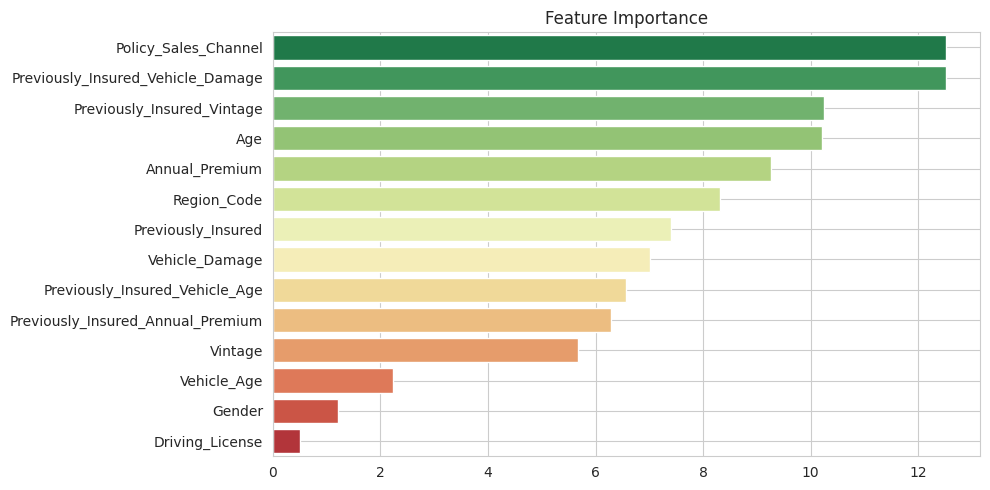

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))

fi = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
sns.barplot(
    y=fi.index, 
    x=fi.values, 
    orient='h', 
    palette=sns.color_palette('RdYlGn_r', len(X.columns))
)
plt.title('Feature Importance')
plt.grid(True)

plt.tight_layout()
plt.show()

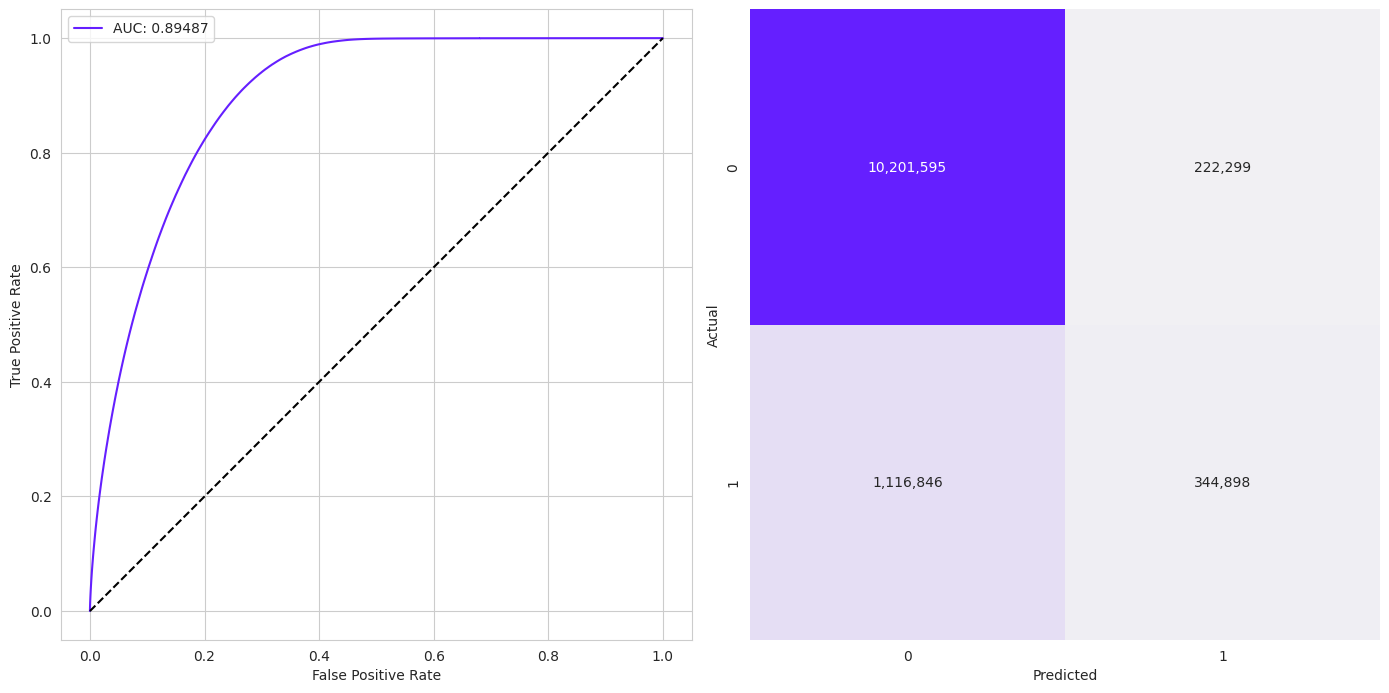

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()